In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [4]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

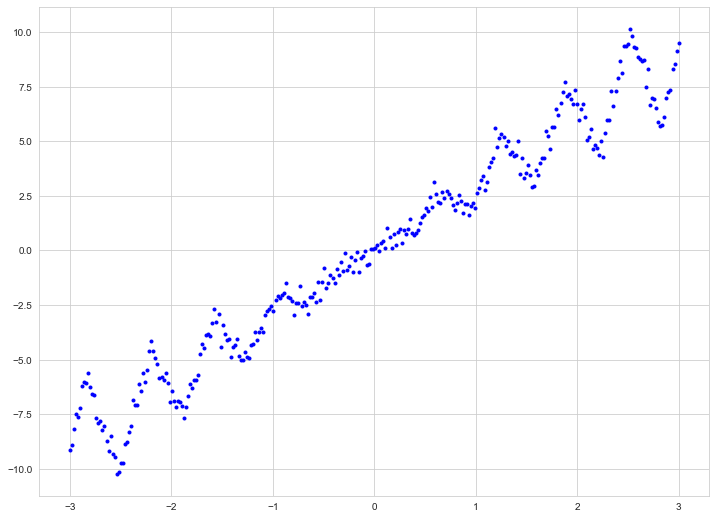

In [5]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [6]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Странная какая-то функция, я ей не доверяю) Я напишу как показывали на занятии, потому что могу)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
def bootstrap_metric(x,
                     y,
                     metric_fn,
                     samples_cnt=1000,
                     alpha=0.05,
                     random_state=42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], 
                                 replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
    
    return b_metric

In [10]:
def train_and_test_regressor(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(f"Fitting {name}")
        model.fit(X_train, y_train)
    predictions = {}
    for name, model in models.items():
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
    boot_scores = {}

    for name, y_pred in predictions.items():
        print(f"Calculating bootstrap score for {name}")
        boot_score = bootstrap_metric(y_test, 
                                      y_pred, 
                                      metric_fn=lambda x, y: mean_squared_error(y_true=x, 
                                                                                y_pred=y))
        boot_scores[name] = boot_score
        
    
    results = pd.DataFrame(boot_scores)
    
    results = results.melt(value_vars=results.columns,
                           value_name="mse", 
                           var_name="model")
    return results

In [155]:
models_depth = {}

for depth in [1, 3, 5, 7, 9, 11, 13, 15, None]:

    models_depth[f"DT_depth{depth}"] = DecisionTreeRegressor(max_depth=depth,
                                                             random_state=42)

results_depth = train_and_test_regressor(models_depth, X_train, y_train, X_test, y_test)

Fitting DT_depth1
Fitting DT_depth3
Fitting DT_depth5
Fitting DT_depth7
Fitting DT_depth9
Fitting DT_depth11
Fitting DT_depth13
Fitting DT_depth15
Fitting DT_depthNone
Calculating bootstrap score for DT_depth1
Calculating bootstrap score for DT_depth3
Calculating bootstrap score for DT_depth5
Calculating bootstrap score for DT_depth7
Calculating bootstrap score for DT_depth9
Calculating bootstrap score for DT_depth11
Calculating bootstrap score for DT_depth13
Calculating bootstrap score for DT_depth15
Calculating bootstrap score for DT_depthNone


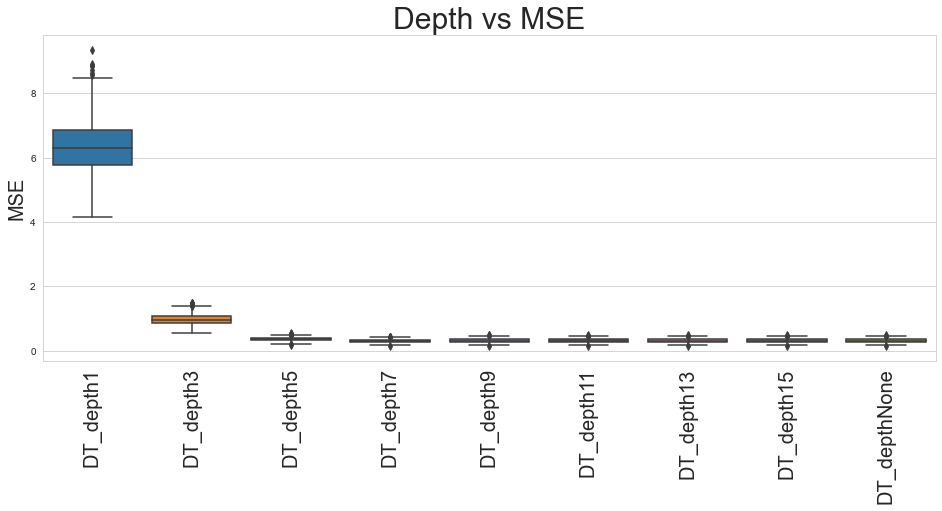

In [16]:
plt.figure(figsize=(16,6))
ax = sns.boxplot(data=results_depth, y="mse", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MSE", size=20)
plt.title("Depth vs MSE", size=30)
plt.xticks(size=20)
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [34]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
predictions = {}


for prob in np.arange(0, 1.01, 0.01):
    inner_prob = 0
    for i in range(51, 102):
        inner_prob += math.comb(101, i) * (prob ** i) * ((1 - prob) ** (101 - i))
    predictions[prob] = inner_prob



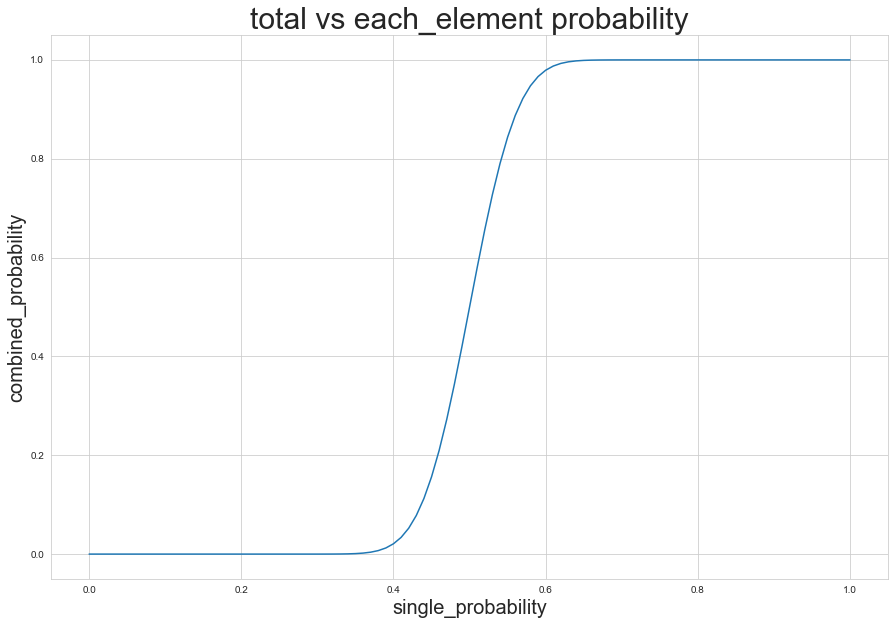

In [40]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=predictions)
plt.xlabel("single_probability", size=20)
plt.ylabel("combined_probability", size=20)
plt.title("total vs each_element probability", size=30)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [46]:
predictions2 = {}


for models_num in range(1, 102):
    inner_prob = 0
    for i in range(1, models_num + 1):
        inner_prob += math.comb(models_num, i) * (0.65 ** i) * ((1 - 0.65) ** (models_num - i))
    predictions2[models_num] = inner_prob


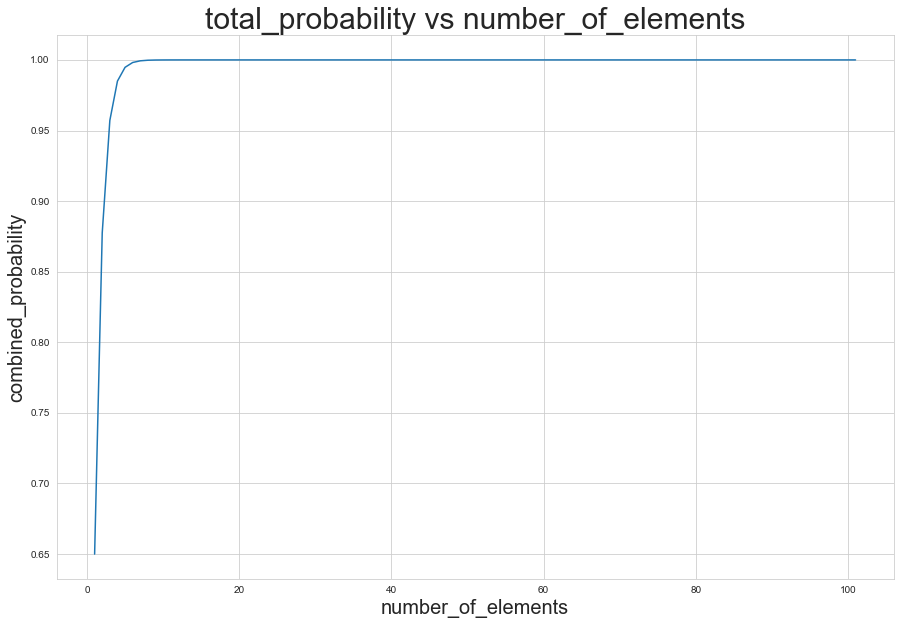

In [47]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=predictions2)
plt.xlabel("number_of_elements", size=20)
plt.ylabel("combined_probability", size=20)
plt.title("total_probability vs number_of_elements", size=30)
plt.show()

Опишите ваши наблюдения:

* На малых значениях вероятности даже большого количества моделей не хватает для правильного предасказания; нужна вероятность хотябы чуть больше 0.5.
* Чем больше моделей, тем больше шанс правильно предсказать результат, насыщение происзодит примерно на 5 моделях.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [128]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        df_X = pd.DataFrame(X)
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i)
            
            if self.max_features != None:
                inner_cols =  random.sample(list(df_X.columns), self.max_features)
                self.feat_ids_by_tree.append(inner_cols)
                inner_X = df_X[inner_cols]
            else:
                self.feat_ids_by_tree.append(df_X.columns)
                inner_X = df_X
            
            row_selector = random.choices(range(len(y)), k=len(y))
            
            inner_X = np.take(inner_X, row_selector, axis=0)
            inner_y = np.take(y, row_selector, axis=0)
            
            self.trees.append(DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state).fit(inner_X, inner_y))
            
        
        return self

    def predict_proba(self, X):
        df_X = pd.DataFrame(X)
        pred_results = [0 for i in range(len(X))]
        for i in range(self.n_estimators):
            inner_tree = self.trees[i]
            inner_cols = self.feat_ids_by_tree[i]
            inner_test_X = df_X[inner_cols]
            
            inner_pred = inner_tree.predict(inner_test_X)
            pred_results = [x + y for x, y in zip(pred_results, inner_pred)]
        final_results = [i / len(self.trees) for i in pred_results]
            
            
        return final_results
    
    def predict(self, X):
        probas = self.predict_proba(X)
        
        return np.array(probas)

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [86]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

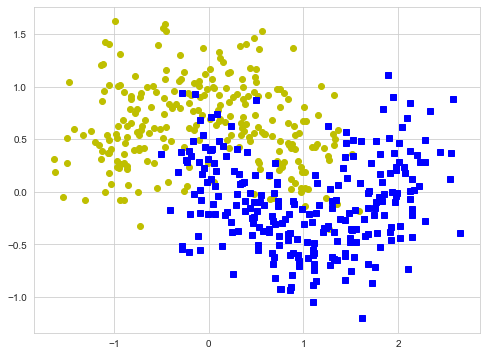

In [111]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [123]:
y_train

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1,

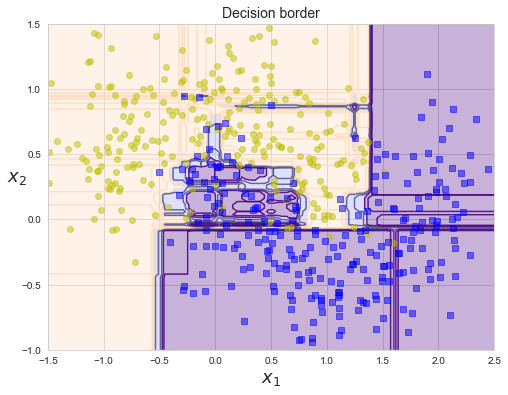

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.figure(figsize=(8, 6))
clf = RandomForestClassifierCustom(random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Выглядит примерно также, как на лекции)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

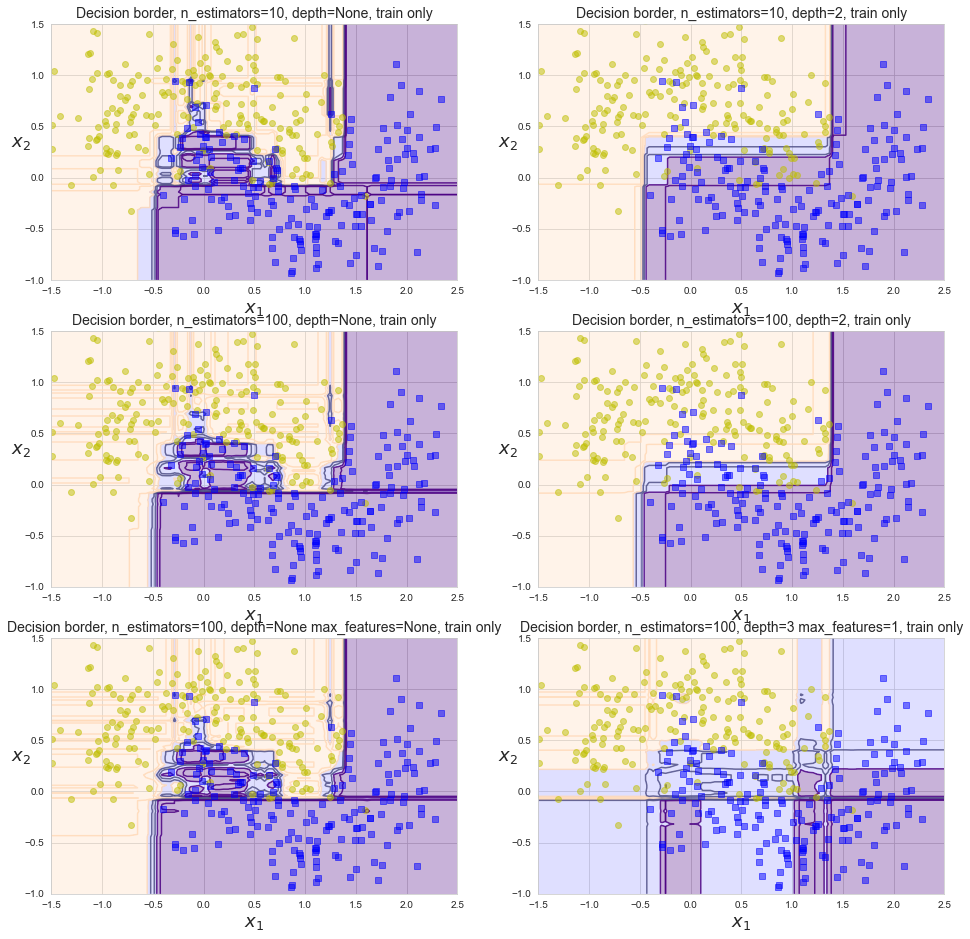

In [139]:
clf1 = RandomForestClassifierCustom(n_estimators=10, max_depth=None, random_state=42)
clf1.fit(X_train, y_train)

clf2 = RandomForestClassifierCustom(n_estimators=10, max_depth=2, random_state=42)
clf2.fit(X_train, y_train)

clf3 = RandomForestClassifierCustom(n_estimators=100, max_depth=None, random_state=42)
clf3.fit(X_train, y_train)

clf4 = RandomForestClassifierCustom(n_estimators=100, max_depth=2, random_state=42)
clf4.fit(X_train, y_train)

clf5 = RandomForestClassifierCustom(n_estimators=100, max_depth=None, max_features=None, random_state=42)
clf5.fit(X_train, y_train)

clf6 = RandomForestClassifierCustom(n_estimators=100, max_depth=3, max_features=1, random_state=42)
clf6.fit(X_train, y_train)

plt.figure(figsize=(16, 16))
plt.subplot(321)
plot_decision_boundary(clf1, X_train, y_train)
plt.title("Decision border, n_estimators=10, depth=None, train only", fontsize=14)
plt.subplot(322)
plot_decision_boundary(clf2, X_train, y_train)
plt.title("Decision border, n_estimators=10, depth=2, train only", fontsize=14)
plt.subplot(323)
plot_decision_boundary(clf3, X_train, y_train)
plt.title("Decision border, n_estimators=100, depth=None, train only", fontsize=14)
plt.subplot(324)
plot_decision_boundary(clf4, X_train, y_train)
plt.title("Decision border, n_estimators=100, depth=2, train only", fontsize=14)
plt.subplot(325)
plot_decision_boundary(clf5, X_train, y_train)
plt.title("Decision border, n_estimators=100, depth=None max_features=None, train only", fontsize=14)
plt.subplot(326)
plot_decision_boundary(clf6, X_train, y_train)
plt.title("Decision border, n_estimators=100, depth=3 max_features=1, train only", fontsize=14)
plt.show()

Ну тут особо нечего подбирать, потому что чем больше деревьев, тем лучше, признака у нас всего два, так что max_features тоже особо не подбираешь, а с одной фичёй получается ерунда. Остаётся подбирать глубину дерева, но в рандомном лесу с большим количеством деревьев это не очень важный параметр)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [140]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [152]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
np.size(X_train, 1)

30

In [161]:
models_max_features = {}

for feature_num in [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, None]:
    models_max_features[f"DT_max_features{feature_num}"] = base_model_pair_correlation(RandomForestClassifier(max_features=feature_num).fit(X_train, y_train), X_train)


In [162]:
results2 = pd.DataFrame(models_max_features)
    
results2 = results2.melt(value_vars=results2.columns,
                           value_name="pair_correlation", 
                           var_name="max_features")

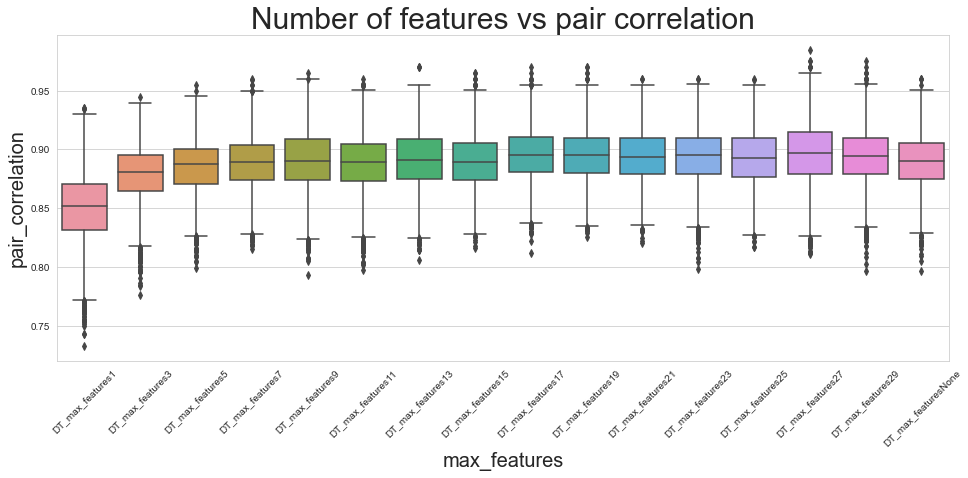

In [165]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results2, y="pair_correlation", x="max_features")
plt.xlabel("max_features", size=20)
plt.xticks(rotation=45)
plt.ylabel("pair_correlation", size=20)
plt.title("Number of features vs pair correlation", size=30)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [166]:
models_max_depth = {}

for depth in [1, 2, 5, 10, 20, 30, 40, 50, 60, 100, None]:
    models_max_depth[f"DT_depth{depth}"] = base_model_pair_correlation(RandomForestClassifier(max_depth=depth).fit(X_train, y_train), X_train)

In [167]:
results3 = pd.DataFrame(models_max_depth)
    
results3 = results3.melt(value_vars=results3.columns,
                           value_name="pair_correlation", 
                           var_name="max_depth")

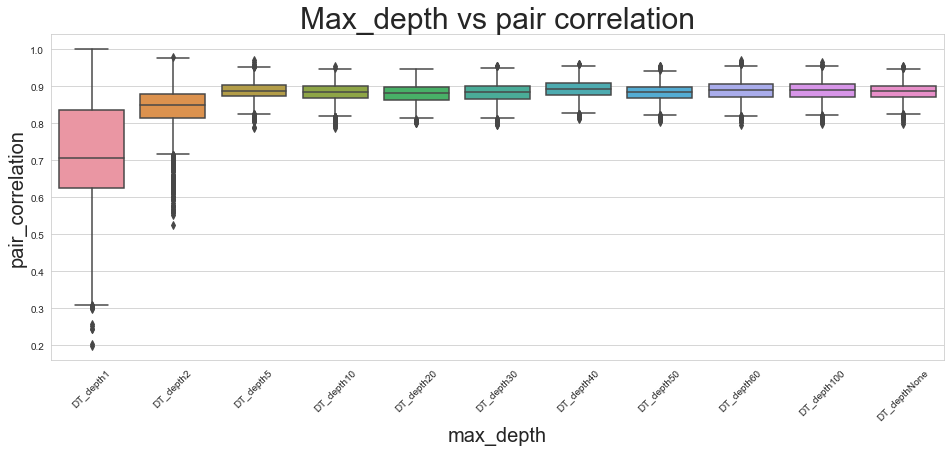

In [169]:
plt.figure(figsize=(16,6))
sns.boxplot(data=results3, y="pair_correlation", x="max_depth")
plt.xlabel("max_depth", size=20)
plt.xticks(rotation=45)
plt.ylabel("pair_correlation", size=20)
plt.title("Max_depth vs pair correlation", size=30)
plt.show()

Опишите ваши наблюдения:

* Чем больше фич, тем больше скоррелированность, потому что "бутстрепнутые" датафреймы меньше отличаются от исходного
* Чем больше глубина, тем больше скоррелированность, потому что на одних и тех же данных деревья переобучаются одинаково)

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за эксперименты и максимально высокий скор**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/ronitf/heart-disease-uci).

In [173]:
heart_dataset = pd.read_csv("D:/downloads/heart.csv")

In [174]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [210]:
dt_params = {  
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,6,8,10,12,14], 
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf':[2,4,6,8,10,12,14],
    'random_state':[SEED]
}

dt = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=dt_params, cv= 5)

rf_params = { 
    'n_estimators': [50, 100], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,6,8,10,12,14], 
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf':[2,4,6,8,10,12,14],
    'random_state':[SEED]
}

rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=rf_params, cv= 5)

etc_params = { 
    'n_estimators': [50, 100], 
    'max_features': ['auto', 'sqrt', 'log2'], 
    'max_depth' : [4,6,8,10,12,14], 
    'criterion' :['gini', 'entropy'],
    'min_samples_leaf':[2,4,6,8,10,12,14],
    'random_state':[SEED]
}

etc = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=etc_params, cv= 5)

knn_params = { 
    'n_neighbors': [5, 7], 
    'weights': ['uniform', 'distance'], 
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
    'leaf_size' :[30,40,50]
}

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=knn_params, cv= 5)

svc_lin_params = {
    'kernel':['linear'],
    'probability': [True],
    'gamma': ['scale', 'auto'], 
    'degree': [3,4,5],
    'random_state':[SEED]
}

svc_lin = GridSearchCV(estimator=SVC(), param_grid=svc_lin_params, cv= 5)

svc_rbf_params = {
    'kernel':['rbf'],
    'probability': [True],
    'gamma': ['scale', 'auto'], 
    'degree': [3,4,5],
    'random_state':[SEED]
}

svc_rbf = GridSearchCV(estimator=SVC(), param_grid=svc_rbf_params, cv= 5)

#эти пусть пока без жадного подбора побудут

cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

lgbm = lightgbm.LGBMClassifier(random_state=SEED)

lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)

xgb = xgboost.XGBClassifier(random_state=SEED)

xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)

lr = LogisticRegression(solver='liblinear', max_iter=10000)

nb = GaussianNB()

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

Раз дают доп. плюшки за модель, то попробую подобрать лучшие параметры GridSearch или аналогами.

In [185]:
dt = dt.fit(X_train,y_train).best_estimator_

In [186]:
rf = rf.fit(X_train,y_train).best_estimator_

In [187]:
etc = etc.fit(X_train,y_train).best_estimator_

In [207]:
knn = knn.fit(X_train,y_train).best_estimator_

In [189]:
svc_lin = svc_lin.fit(X_train,y_train).best_estimator_

In [190]:
svc_rbf = svc_rbf.fit(X_train,y_train).best_estimator_

In [191]:
cat.fit(X_train,y_train)

In [192]:
lgbm.fit(X_train,y_train)

LGBMClassifier(random_state=111)

In [193]:
lgbm_rf.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, boosting_type='rf',
               random_state=111)

In [194]:
xgb.fit(X_train,y_train)

[23:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=111,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [195]:
xgb_rf.fit(X_train,y_train)

[23:45:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=111, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [196]:
lr.fit(X_train,y_train)

LogisticRegression(max_iter=10000, solver='liblinear')

In [197]:
nb.fit(X_train,y_train)

GaussianNB()

In [211]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]



voting_hard = VotingClassifier(base_models, voting='hard')

voting_soft = VotingClassifier(base_models, voting='soft')

In [212]:
voting_hard.fit(X_train,y_train)

[00:10:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:10:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('DT',
                              GridSearchCV(cv=5,
                                           estimator=DecisionTreeClassifier(),
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [4, 6, 8,
                                                                     10, 12,
                                                                     14],
                                                       'max_features': ['auto',
                                                                        'sqrt',
                                                                        'log2'],
                                                       'min_samples_leaf': [2,
                                                                            4,
                                                  

In [213]:
voting_soft.fit(X_train,y_train)

[00:18:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:18:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('DT',
                              GridSearchCV(cv=5,
                                           estimator=DecisionTreeClassifier(),
                                           param_grid={'criterion': ['gini',
                                                                     'entropy'],
                                                       'max_depth': [4, 6, 8,
                                                                     10, 12,
                                                                     14],
                                                       'max_features': ['auto',
                                                                        'sqrt',
                                                                        'log2'],
                                                       'min_samples_leaf': [2,
                                                                            4,
                                                  

In [214]:
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

GridSearchCV: 0.7647731942468784
GridSearchCV: 0.8469846660491921
CatBoostClassifier: 0.8342715174922052
GridSearchCV: 0.8490529791271825
GridSearchCV: 0.6548304328424811
GridSearchCV: 0.8403098469098905
GridSearchCV: 0.6973119072190279
[00:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default ev

KeyboardInterrupt: 

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [127]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [ ]:
corrs = base_model_pair_correlation_for_voting_clf([dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft], X_train)

    

Что-то у меня с гридсёрчем не так получилось, и все модели очень долго считались, поэтому на отсев сильно скоррелированных моделей не осталось времени(

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [215]:
data = pd.read_csv("D:/downloads/churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

In [216]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [217]:
data.dtypes

State              object
Account Length      int64
Area Code           int64
Phone              object
Int'l Plan         object
VMail Plan         object
VMail Message       int64
Day Mins          float64
Day Calls           int64
Day Charge        float64
Eve Mins          float64
Eve Calls           int64
Eve Charge        float64
Night Mins        float64
Night Calls         int64
Night Charge      float64
Intl Mins         float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?             object
dtype: object

In [218]:
data.nunique()

State               51
Account Length     212
Area Code            3
Phone             3333
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

In [219]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

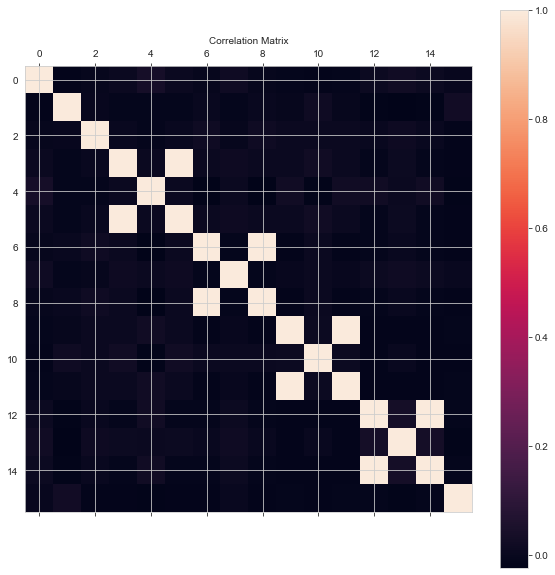

In [220]:
f = plt.figure(figsize=(10, 10))
plt.matshow(data.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

In [222]:
data.corr()

Account Length  Area Code  VMail Message  Day Mins  Day Calls  \
Account Length        1.000000  -0.012463      -0.004628  0.006216   0.038470   
Area Code            -0.012463   1.000000      -0.001994 -0.008264  -0.009646   
VMail Message        -0.004628  -0.001994       1.000000  0.000778  -0.009548   
Day Mins              0.006216  -0.008264       0.000778  1.000000   0.006750   
Day Calls             0.038470  -0.009646      -0.009548  0.006750   1.000000   
Day Charge            0.006214  -0.008264       0.000776  1.000000   0.006753   
Eve Mins             -0.006757   0.003580       0.017562  0.007043  -0.021451   
Eve Calls             0.019260  -0.011886      -0.005864  0.015769   0.006462   
Eve Charge           -0.006745   0.003607       0.017578  0.007029  -0.021449   
Night Mins           -0.008955  -0.005825       0.007681  0.004323   0.022938   
Night Calls          -0.013176   0.016522       0.007123  0.022972  -0.019557   
Night Charge         -0.008960  -0.005845       0.007663  0.004300   0.022927   
Intl Mins             0.009514  -0.018288       0.002856 -0.010155   0.021565   
Intl Calls            0.020661  -0.024179       0.013957  0.008033   0.004574   
Intl Charge           0.009546  -0.018395       0.002884 -0.010092   0.021666   
CustServ Calls       -0.003796   0.027572      -0.013263 -0.013423  -0.018942   

                Day Charge  Eve Mins  Eve Calls  Eve Charge  Night Mins  \
Account Length    0.006214 -0.006757   0.019260   -0.006745   -0.008955   
Area Code        -0.008264  0.003580  -0.011886    0.003607   -0.005825   
VMail Message     0.000776  0.017562  -0.005864    0.017578    0.007681   
Day Mins          1.000000  0.007043   0.015769    0.007029    0.004323   
Day Calls         0.006753 -0.021451   0.006462   -0.021449    0.022938   
Day Charge        1.000000  0.007050   0.015769    0.007036    0.004324   
Eve Mins          0.007050  1.000000  -0.011430    1.000000   -0.012584   
Eve Calls         0.015769 -0.011430   1.000000   -0.011423   -0.002093   
Eve Charge        0.007036  1.000000  -0.011423    1.000000   -0.012592   
Night Mins        0.004324 -0.012584  -0.002093   -0.012592    1.000000   
Night Calls       0.022972  0.007586   0.007710    0.007596    0.011204   
Night Charge      0.004301 -0.012593  -0.002056   -0.012601    0.999999   
Intl Mins        -0.010157 -0.011035   0.008703   -0.011043   -0.015207   
Intl Calls        0.008032  0.002541   0.017434    0.002541   -0.012353   
Intl Charge      -0.010094 -0.011067   0.008674   -0.011074   -0.015180   
CustServ Calls   -0.013427 -0.012985   0.002423   -0.012987   -0.009288   

                Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
Account Length    -0.013176     -0.008960   0.009514    0.020661     0.009546   
Area Code          0.016522     -0.005845  -0.018288   -0.024179    -0.018395   
VMail Message      0.007123      0.007663   0.002856    0.013957     0.002884   
Day Mins           0.022972      0.004300  -0.010155    0.008033    -0.010092   
Day Calls         -0.019557      0.022927   0.021565    0.004574     0.021666   
Day Charge         0.022972      0.004301  -0.010157    0.008032    -0.010094   
Eve Mins           0.007586     -0.012593  -0.011035    0.002541    -0.011067   
Eve Calls          0.007710     -0.002056   0.008703    0.017434     0.008674   
Eve Charge         0.007596     -0.012601  -0.011043    0.002541    -0.011074   
Night Mins         0.011204      0.999999  -0.015207   -0.012353    -0.015180   
Night Calls        1.000000      0.011188  -0.013605    0.000305    -0.013630   
Night Charge       0.011188      1.000000  -0.015214   -0.012329    -0.015186   
Intl Mins         -0.013605     -0.015214   1.000000    0.032304     0.999993   
Intl Calls         0.000305     -0.012329   0.032304    1.000000     0.032372   
Intl Charge       -0.013630     -0.015186   0.999993    0.032372     1.000000   
CustServ Calls    -0.012802     -0.009277  -0.009640   -0.017561  

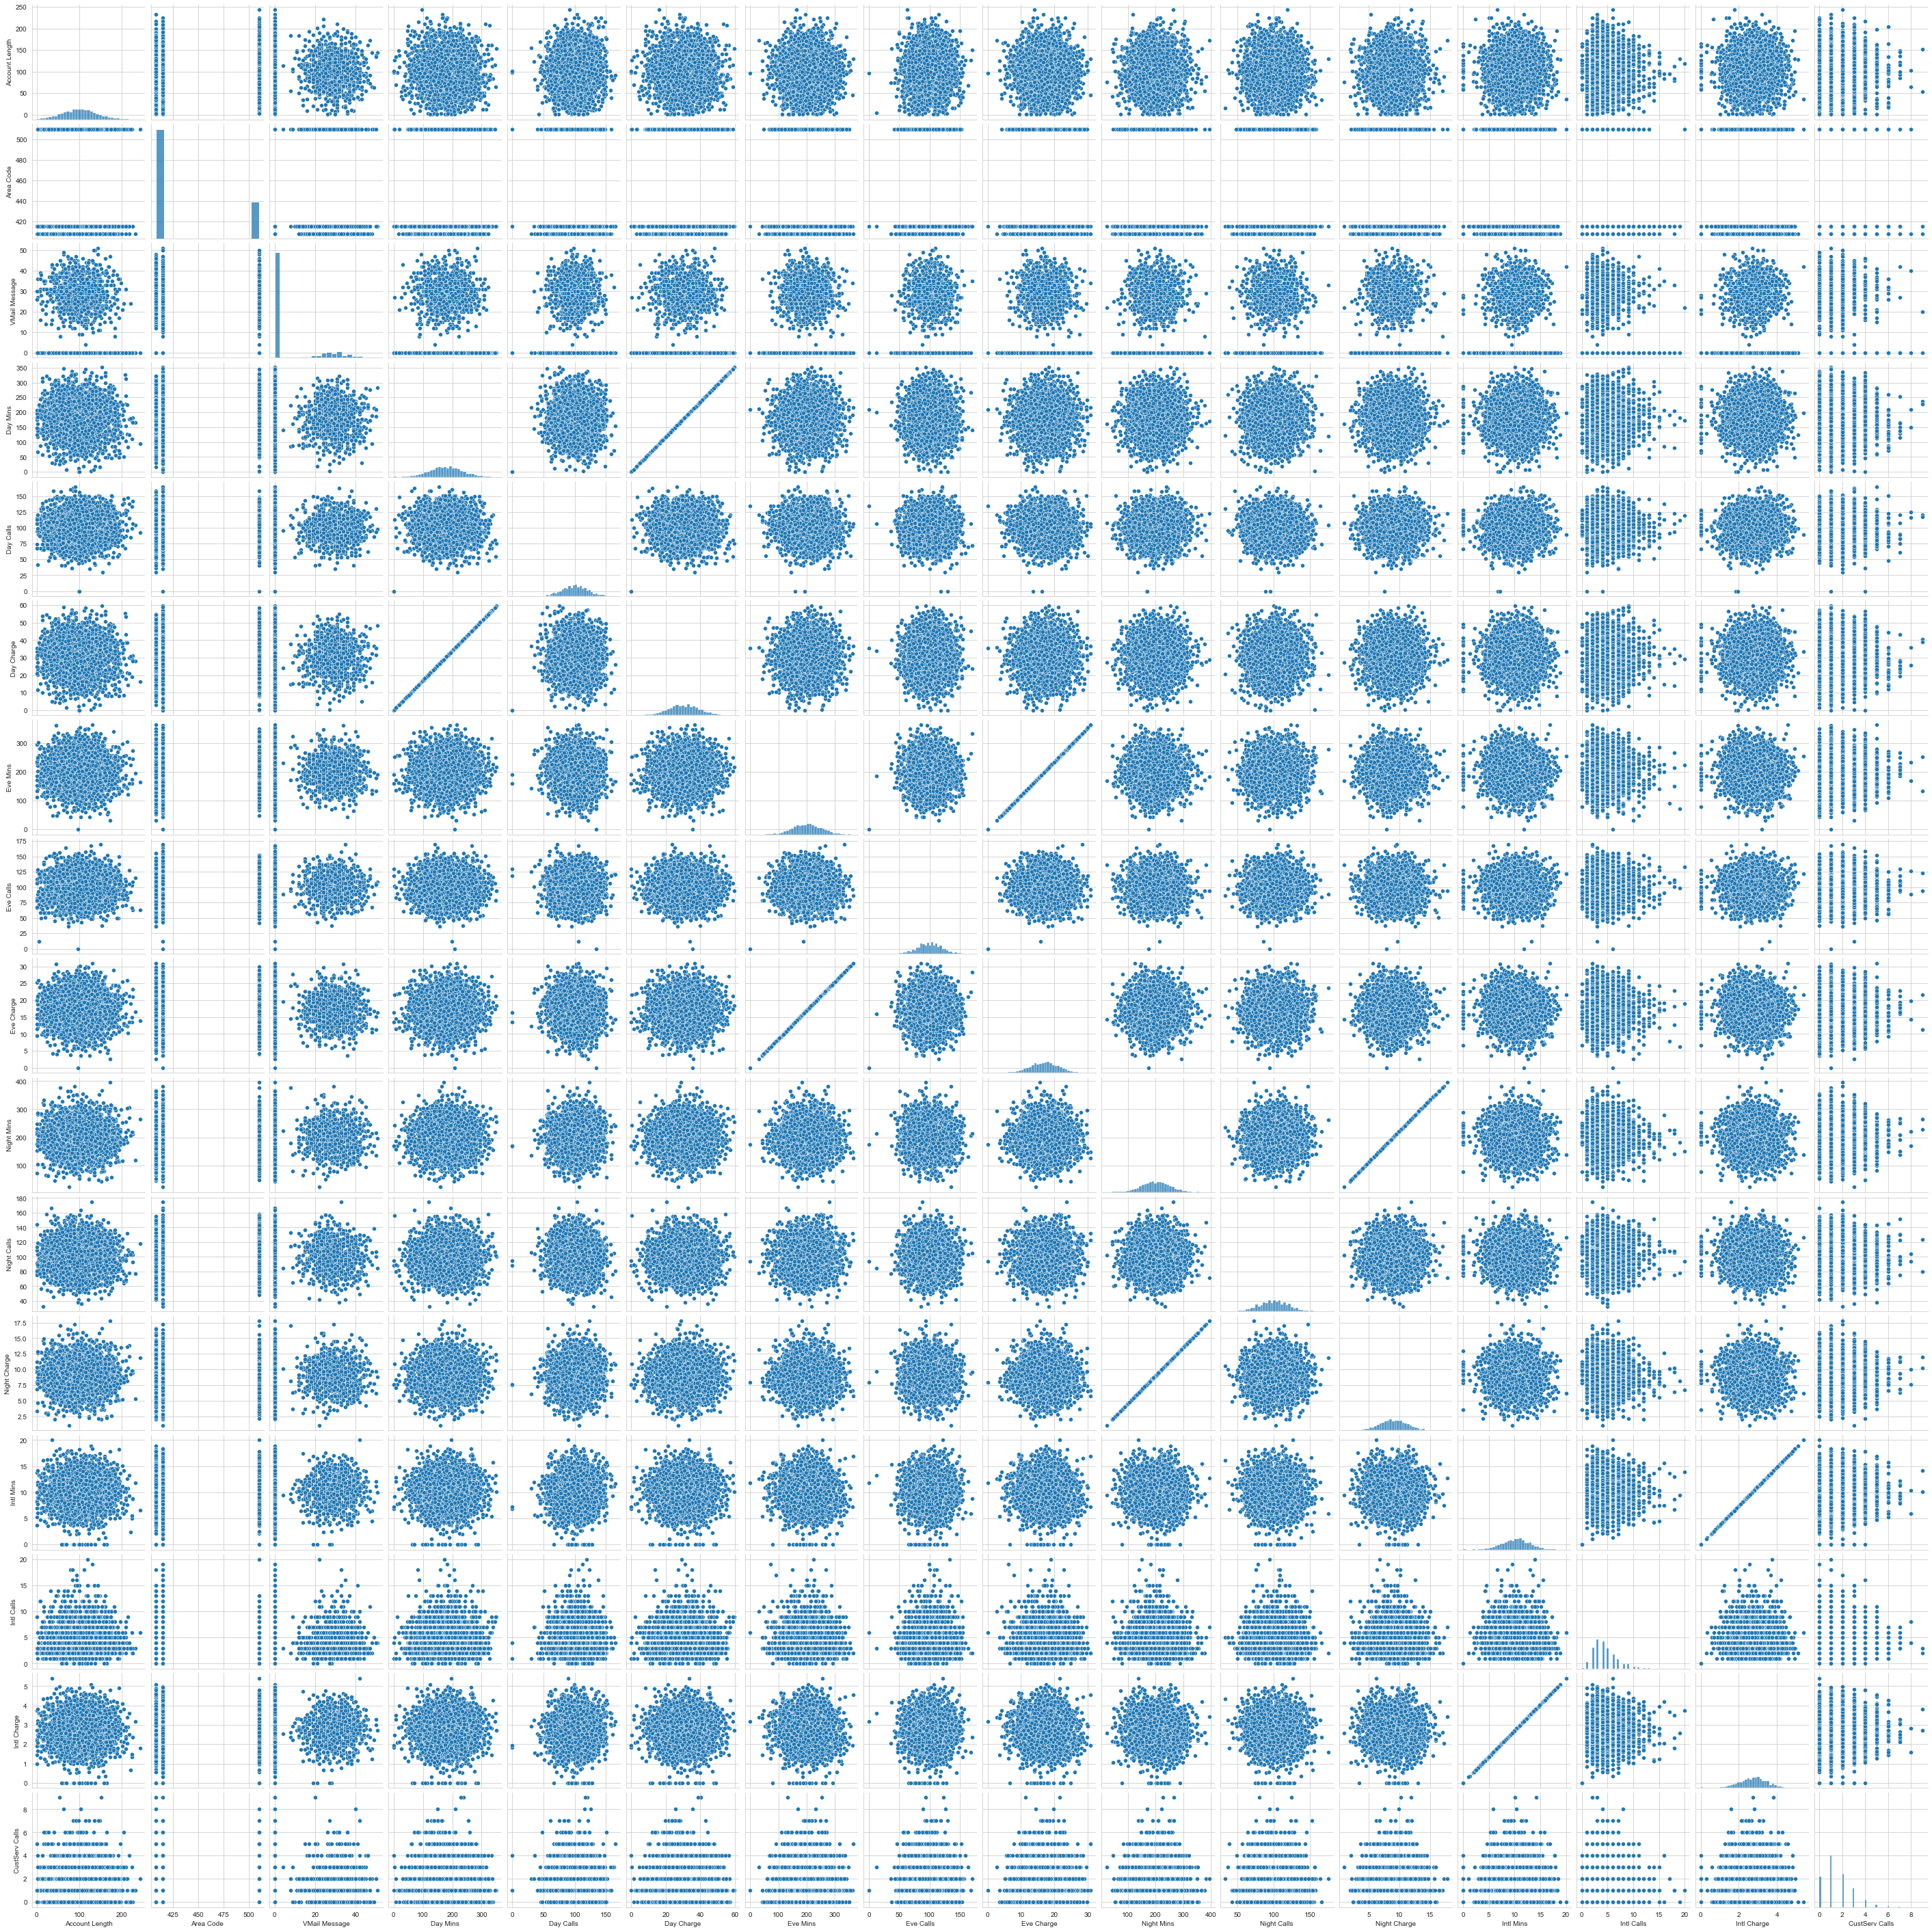

In [221]:
sns.pairplot(data)

Вау. У нас есть несколько переменных, которые по сути одна переменная:
Day Charge-Day Mins;
Eve Charge-Eve Mins;
Night Charge-Night Mins;
Intl Charge-Intl Mins

Сразу дропнем те, что с Mins

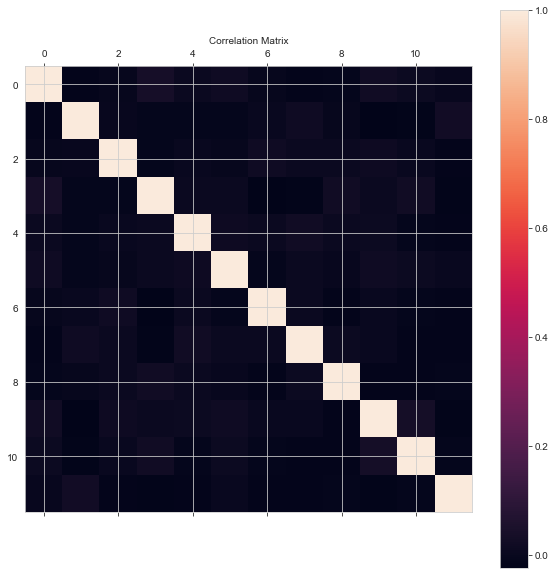

In [223]:
data_2 = data.drop(['Day Mins', 'Eve Mins', 'Night Mins', 'Intl Mins'], axis=1)
f = plt.figure(figsize=(10, 10))
plt.matshow(data_2.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

Так-то лучше. Также дропнем Phone потому что это уникальный идентификатор, мы по нему ничего не предскажем. State я тоже дропну, потому что делать 52 столбца нулей и единиц не хочется. Вместо yes и no в Int'l Plan и VMail Plan проставлю 0 и 1, это выглядит логично)

In [224]:
data_2 = data_2.drop(['State', 'Phone'], axis=1)

In [227]:
data_2['Int\'l Plan'] = data_2['Int\'l Plan'].eq('yes').mul(1)

In [228]:
data_2['VMail Plan'] = data_2['VMail Plan'].eq('yes').mul(1)

In [245]:
data_2['Churn?'] = data['Churn?'].eq('True.').mul(1)

In [234]:
data_2.dtypes

Account Length      int64
Area Code           int64
Int'l Plan          int32
VMail Plan          int32
VMail Message       int64
Day Calls           int64
Day Charge        float64
Eve Calls           int64
Eve Charge        float64
Night Calls         int64
Night Charge      float64
Intl Calls          int64
Intl Charge       float64
CustServ Calls      int64
Churn?              int32
dtype: object

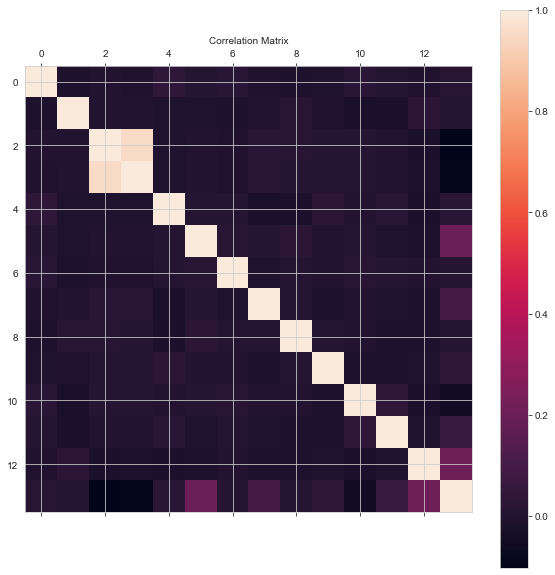

In [248]:
f = plt.figure(figsize=(10, 10))
plt.matshow(data_2.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10);

Ага. Можно оставить либо Int'l Plan, либо VMail Plan.

In [236]:
data_2 = data_2.drop(['Int\'l Plan'], axis=1)

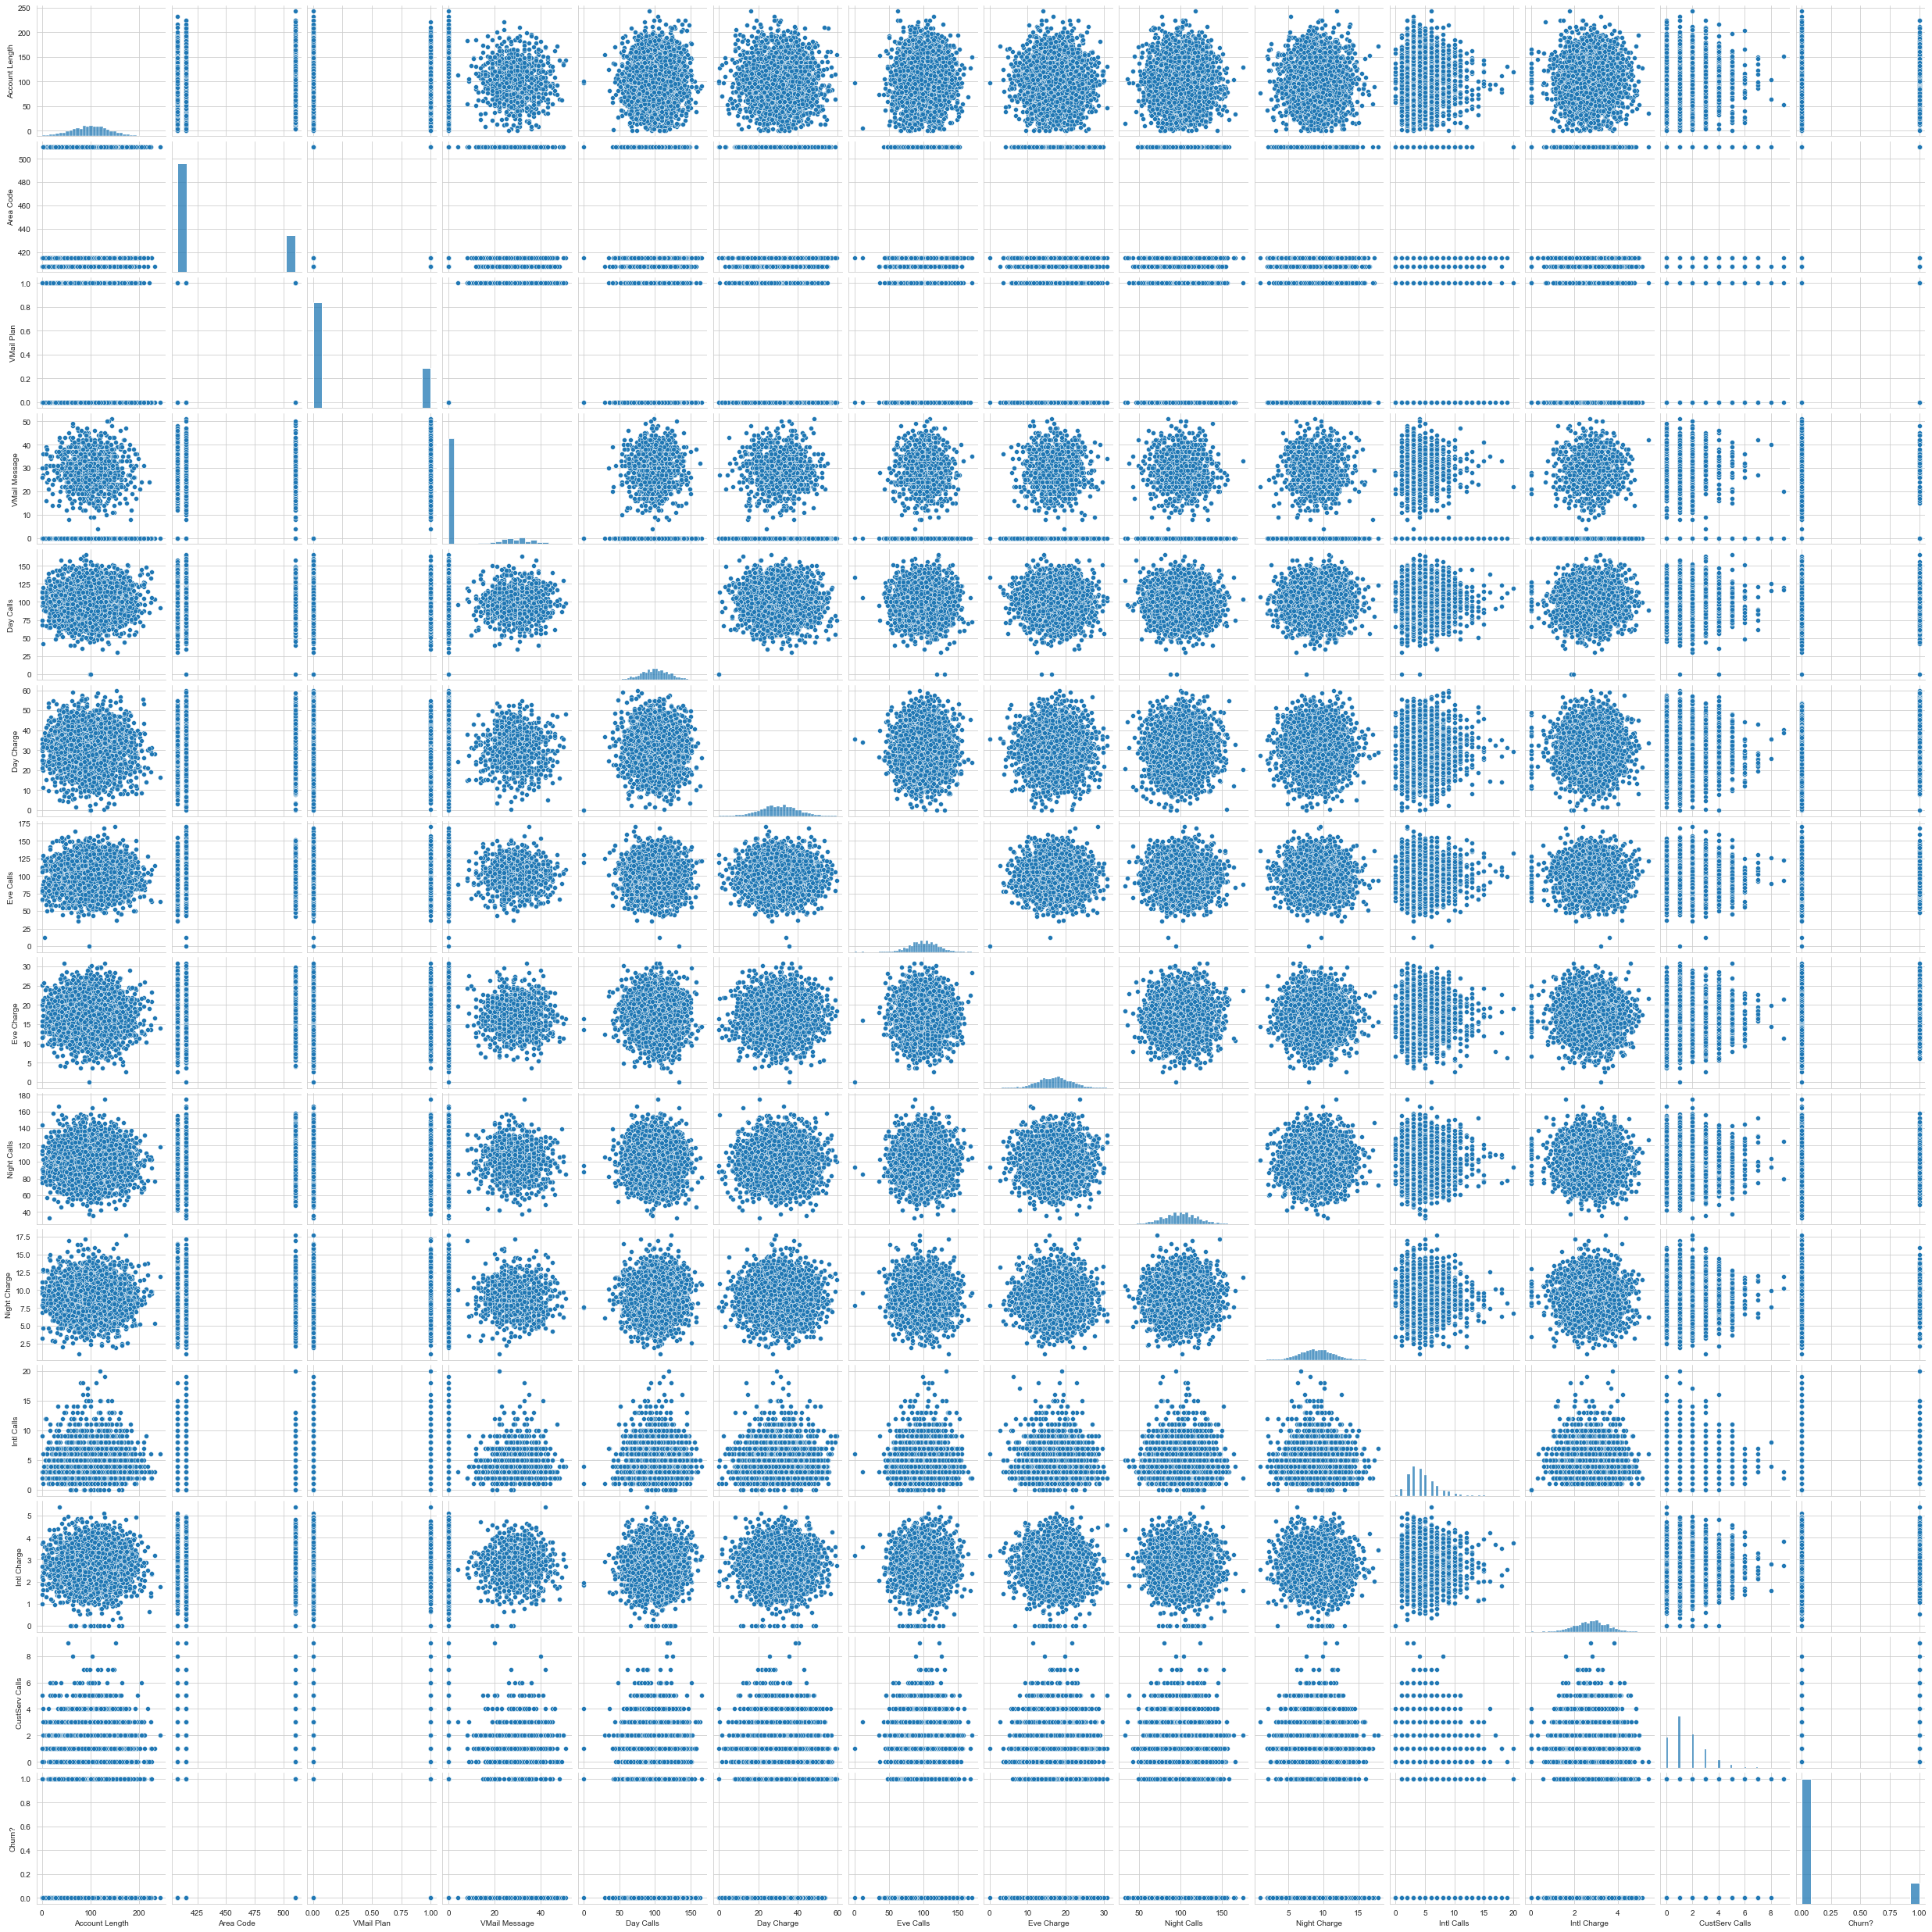

In [247]:
sns.pairplot(data_2)

Я бы ещё повыделывался с данными, но не успеваю, поэтому буду предсказывать. Выбираю:
xgboost.XGBRFClassifier
catboost.CatBoostClassifier

In [249]:
X_train, X_test, y_train, y_test = train_test_split(data_2.drop(['Churn?'], axis=1), data_2['Churn?'], random_state=42)

In [251]:
ranfor = xgboost.XGBRFClassifier()
ranfor.fit(X_train, y_train)

[01:50:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=8,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='exact', validate_parameters=1,
                verbosity=None)

In [252]:
cross_val_score(ranfor, X_test, y_test, cv=3, scoring="f1")

[01:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:51:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.57894737, 0.65671642, 0.56338028])

In [256]:
booster = catboost.CatBoostClassifier()
booster.fit(X_train, y_train)

Learning rate set to 0.015233
0:	learn: 0.6795442	total: 8.75ms	remaining: 8.74s
1:	learn: 0.6647471	total: 11.7ms	remaining: 5.85s
2:	learn: 0.6513830	total: 14.2ms	remaining: 4.71s
3:	learn: 0.6378773	total: 16.7ms	remaining: 4.15s
4:	learn: 0.6276884	total: 18.3ms	remaining: 3.63s
5:	learn: 0.6169156	total: 20.2ms	remaining: 3.34s
6:	learn: 0.6074848	total: 22.9ms	remaining: 3.25s
7:	learn: 0.5961106	total: 25.7ms	remaining: 3.19s
8:	learn: 0.5843224	total: 28.5ms	remaining: 3.14s
9:	learn: 0.5728587	total: 31.2ms	remaining: 3.09s
10:	learn: 0.5625216	total: 33.7ms	remaining: 3.03s
11:	learn: 0.5542526	total: 36.1ms	remaining: 2.97s
12:	learn: 0.5446551	total: 38.7ms	remaining: 2.94s
13:	learn: 0.5350286	total: 41.2ms	remaining: 2.9s
14:	learn: 0.5256870	total: 43.6ms	remaining: 2.86s
15:	learn: 0.5172668	total: 46ms	remaining: 2.83s
16:	learn: 0.5098087	total: 48.4ms	remaining: 2.8s
17:	learn: 0.5013446	total: 50.8ms	remaining: 2.77s
18:	learn: 0.4949652	total: 53.5ms	remaining: 2.

In [257]:
cross_val_score(booster, X_test, y_test, cv=3, scoring="f1")

Learning rate set to 0.008018
0:	learn: 0.6867259	total: 16.4ms	remaining: 16.4s
1:	learn: 0.6806523	total: 18.7ms	remaining: 9.33s
2:	learn: 0.6724821	total: 21.2ms	remaining: 7.05s
3:	learn: 0.6638734	total: 23.2ms	remaining: 5.79s
4:	learn: 0.6582434	total: 24.7ms	remaining: 4.92s
5:	learn: 0.6517913	total: 26.3ms	remaining: 4.35s
6:	learn: 0.6458493	total: 28.5ms	remaining: 4.05s
7:	learn: 0.6387097	total: 30.4ms	remaining: 3.77s
8:	learn: 0.6314155	total: 32.2ms	remaining: 3.54s
9:	learn: 0.6234018	total: 33.9ms	remaining: 3.36s
10:	learn: 0.6158943	total: 35.8ms	remaining: 3.22s
11:	learn: 0.6101373	total: 37.6ms	remaining: 3.1s
12:	learn: 0.6027280	total: 39.4ms	remaining: 2.99s
13:	learn: 0.5968361	total: 41.1ms	remaining: 2.9s
14:	learn: 0.5924820	total: 43.3ms	remaining: 2.84s
15:	learn: 0.5857381	total: 45.2ms	remaining: 2.78s
16:	learn: 0.5818461	total: 46.9ms	remaining: 2.71s
17:	learn: 0.5751550	total: 48.7ms	remaining: 2.66s
18:	learn: 0.5702888	total: 50.6ms	remaining: 

array([0.64788732, 0.65625   , 0.51612903])

Одинаково плохо, примерно 50%. Но времени уже не хватает, поэтому буду грузить так(

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

                             Z             
                       Z                   
        .,.,        z           
      (((((())    z             
     ((('_  _`) '               
     ((G   \ |)                 
    (((`   " ,                  
     .((\.:~:          .--------------.    
     __.| `"'.__      | \              |     
  .~~   `---'   ~.    |  .             :     
 /                `   |   `-.__________)     
|             ~       |  :             :   
|                     |  :  |              
|    _                |     |   [ ##   :   
 \    ~~-.            |  ,   oo_______.'   
  `_   ( \) _____/~~~~ `--___              
  | ~`-)  ) `-.   `---   ( - a:f -         
  |   '///`  | `-.                         
  |     | |  |    `-.                      
  |     | |  |       `-.                   
  |     | |\ |                             
  |     | | \|                             
   `-.  | |  |                             
      `-| '

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**